In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install language-tool-python
!pip install spacy textstat
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.metrics.pairwise import cosine_similarity
import string
import seaborn as sns
import matplotlib.pyplot as plt
import language_tool_python
import textstat
from scipy.sparse import hstack
import spacy
import scipy.sparse as sp
import string
import seaborn as sns
import matplotlib.pyplot as pltimport nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy



# Defining file paths for the training and testing datasets stored on Google Drive.


In [ ]:
train_path="/content/drive/MyDrive/AI_Content_Detector/updated_dataset/train_df.csv"
test_path ="/content/drive/MyDrive/AI_Content_Detector/updated_dataset/test_df.csv"

# Load  datasets


In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(9331, 2)
(2333, 2)


### Using a small subset of the data


In [ ]:
# train_df = train_df.sample(n=100, random_state=42)
# test_df = test_df.sample(n=10, random_state=42)

In [ ]:
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en')

INFO:language_tool_python.download_lt:Unzipping /tmp/tmpc2zf7w22.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.


# Feature Constructions

vocabSize: Vocabulary Size

In [ ]:
def vocabSize(sentence):

    doc = nlp(sentence.lower())
    tokens = set([token.text for token in doc if not token.is_punct])
    vocab_size = len(tokens)

    return vocab_size

sentence complexity of paragraph

In [ ]:
def sentence_complexity(sentence):

  flesch_score = textstat.flesch_reading_ease(sentence) # Flesch Reading Ease: Measures the readability of a sentence. Higher scores indicate easier readability.
  fk_grade_level = textstat.flesch_kincaid_grade(sentence) # Flesch-Kincaid Grade Level: Indicates the grade level required to understand the text. Higher scores mean more complex text.
  gunning_fog = textstat.gunning_fog(sentence) # Gunning Fog Index: Measures the readability of the text, considering sentence length and complex words (3+ syllables). Higher values indicate more complex text.
  smog_index = textstat.smog_index(sentence)  # SMOG Index: Estimates the years of education required to understand the text. Higher values indicate more complex text.
  composite_score = (flesch_score * 0.2 + fk_grade_level * 0.3 + gunning_fog * 0.3 + smog_index * 0.2)
    # print(f"Composite Sentence Complexity Score(In scale of 1 - 20): {composite_score}")

  return composite_score

Grammatical mistakes

In [ ]:
def grammatical_mistakes(sentence):

  mistakes = len(tool.check(sentence))

  return mistakes

Punctuation_count: The total number of punctuation marks in a given text, such as commas, periods, exclamation points, question marks, and other symbols

In [ ]:
def punctuation_count(paragraph):
    # Create a dictionary to store counts of each punctuation mark
    punctuation_counts = {p: 0 for p in string.punctuation}

    # Count each punctuation mark in the paragraph
    for char in paragraph:
        if char in string.punctuation:
            punctuation_counts[char] += 1

    # Calculate the total number of punctuation marks
    total_punctuation = sum(punctuation_counts.values())

    return total_punctuation


Sentence Length Difference:
The difference between the lengths of the shortest and longest sentences within a paragraph.

In [ ]:
def sentence_length_difference(paragraph):

    # Split the paragraph into sentences using common sentence delimiters
    import re
    sentences = re.split(r'[.!?]', paragraph)

    # Remove empty strings and whitespace from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Calculate the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Calculate the difference between the smallest and largest sentence length
    length_difference = max(sentence_lengths) - min(sentence_lengths) if sentence_lengths else 0

    return length_difference



Type-Token Ratio (TTR):
A measure of vocabulary diversity in a given text.

In [ ]:
def type_token_ratio(text):
    """
    Calculates the Type-Token Ratio (TTR) for vocabulary diversity.
    """
    words = text.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0
    return ttr

Character Count: Total number of characters in the text.

In [ ]:
train_df['character_count'] = train_df['text'].str.len()
test_df['character_count'] = test_df['text'].str.len()


Word Count: Total number of words in the text.

In [ ]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))


Sentence Count: Number of sentences in the text.

In [ ]:
train_df['sentence_count'] = train_df['text'].apply(lambda x: len(re.split(r'[.!?]', x.strip())) - 1)
test_df['sentence_count'] = test_df['text'].apply(lambda x: len(re.split(r'[.!?]', x.strip())) - 1)


Paragraph Count: Number of paragraphs in the text.

In [ ]:
train_df['paragraph_count'] = train_df['text'].apply(lambda x: len(x.split("\n")))
test_df['paragraph_count'] = test_df['text'].apply(lambda x: len(x.split("\n")))



Stopword Count: Number of stopwords in the text.

In [ ]:
stop_words = set(stopwords.words('english'))
train_df['stopword_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
test_df['stopword_count'] = test_df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))


Unique Word Count: Number of unique words in the text.

In [ ]:
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(x.split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(x.split())))


Part-of-Speech (POS) Counts: Distribution of parts of speech in the text.

In [ ]:
nlp = spacy.load("en_core_web_sm")

def pos_counts(text):
    doc = nlp(text)
    pos_count_dict = {}
    for token in doc:
        pos = token.pos_
        pos_count_dict[pos] = pos_count_dict.get(pos, 0) + 1
    return pos_count_dict

train_df['pos_counts'] = train_df['text'].apply(pos_counts)
test_df['pos_counts'] = test_df['text'].apply(pos_counts)


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Sentiment Analysis (Polarity and Subjectivity):

In [ ]:
from textblob import TextBlob

train_df['sentiment_polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['sentiment_subjectivity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

test_df['sentiment_polarity'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['sentiment_subjectivity'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


Discourse Marker Count: Number of discourse markers (connectors like "however", "therefore", etc.).

In [ ]:
discourse_markers = ["however", "therefore", "although", "nevertheless", "hence"]

def count_discourse_markers(text):
    return sum(text.lower().count(marker) for marker in discourse_markers)

train_df['discourse_marker_count'] = train_df['text'].apply(count_discourse_markers)
test_df['discourse_marker_count'] = test_df['text'].apply(count_discourse_markers)


In [ ]:
train_df['vocab_size'] = train_df['text'].apply(vocabSize)
train_df['sentence_complexity'] = train_df['text'].apply(sentence_complexity)
train_df['grammatical_mistakes'] = train_df['text'].apply(grammatical_mistakes)
train_df['punctuation_count'] = train_df['text'].apply(punctuation_count)
train_df['sentence_length_difference'] = train_df['text'].apply(sentence_length_difference)
train_df['type_token_ratio'] = train_df['text'].apply(type_token_ratio)

In [ ]:
test_df['vocab_size'] = test_df['text'].apply(vocabSize)
test_df['sentence_complexity'] = test_df['text'].apply(sentence_complexity)
test_df['grammatical_mistakes'] = test_df['text'].apply(grammatical_mistakes)
test_df['punctuation_count'] = test_df['text'].apply(punctuation_count)
test_df['sentence_length_difference'] = test_df['text'].apply(sentence_length_difference)
test_df['type_token_ratio'] = test_df['text'].apply(type_token_ratio)

In [ ]:
train_df.columns

Index(['text', 'label', 'character_count', 'word_count', 'sentence_count',
       'paragraph_count', 'stopword_count', 'unique_word_count', 'pos_counts',
       'sentiment_polarity', 'sentiment_subjectivity',
       'discourse_marker_count', 'vocab_size', 'sentence_complexity',
       'grammatical_mistakes', 'punctuation_count',
       'sentence_length_difference', 'type_token_ratio'],
      dtype='object')

In [ ]:
numeric_train_df = train_df.select_dtypes(include=['float64', 'int64'])


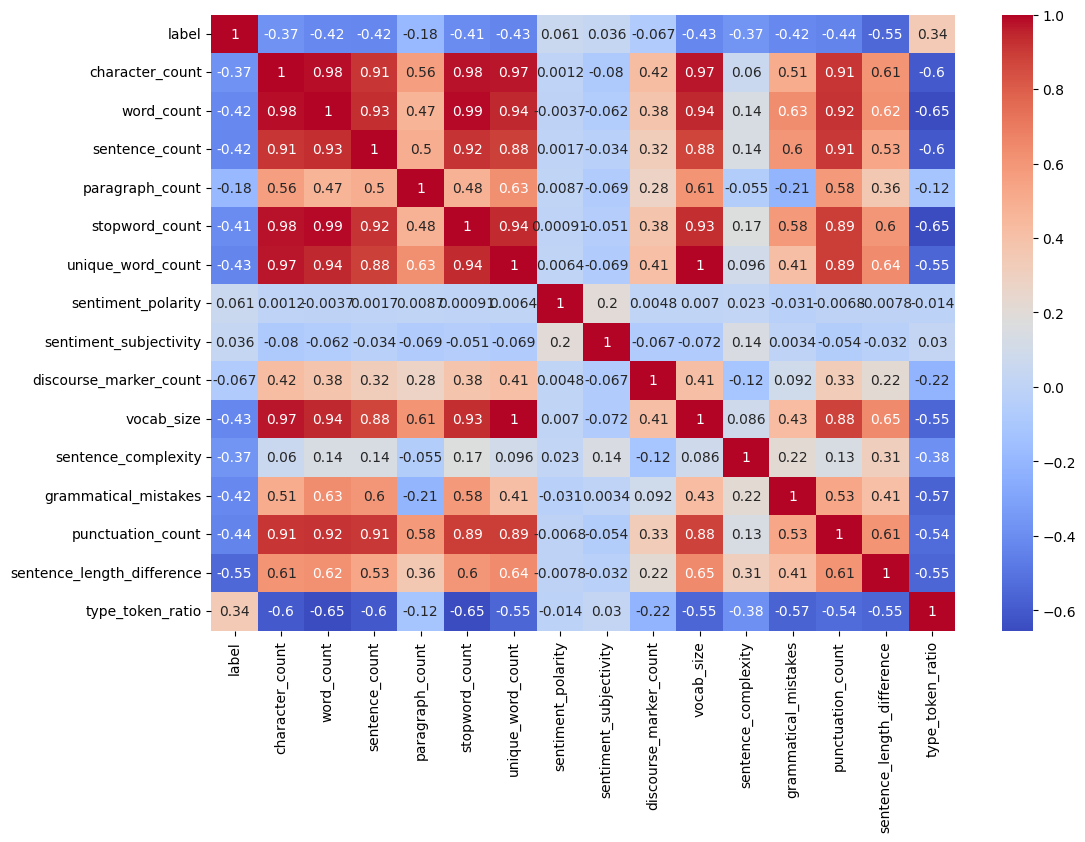

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_train_df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [ ]:
train_df.columns


Index(['text', 'label', 'character_count', 'word_count', 'sentence_count',
       'paragraph_count', 'stopword_count', 'unique_word_count', 'pos_counts',
       'sentiment_polarity', 'sentiment_subjectivity',
       'discourse_marker_count', 'vocab_size', 'sentence_complexity',
       'grammatical_mistakes', 'punctuation_count',
       'sentence_length_difference', 'type_token_ratio'],
      dtype='object')

In [ ]:
test_df.columns

Index(['text', 'label', 'character_count', 'word_count', 'sentence_count',
       'paragraph_count', 'stopword_count', 'unique_word_count', 'pos_counts',
       'sentiment_polarity', 'sentiment_subjectivity',
       'discourse_marker_count', 'vocab_size', 'sentence_complexity',
       'grammatical_mistakes', 'punctuation_count',
       'sentence_length_difference', 'type_token_ratio'],
      dtype='object')

In [ ]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)